In [30]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [5]:
df_raw_1 = pd.read_csv('./data/jeju_data_ver1/201901-202003.csv')
df_raw_2 = pd.read_csv('./data/jeju_data_ver1/202004.csv')

df_raw = pd.concat([df_raw_1, df_raw_2])

In [6]:
df_raw.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
1350321,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


# Data Preprocessing

In [120]:
df = df_raw.copy()

In [121]:
df.fillna('세종시', inplace=True)

In [122]:
df

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7


In [123]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [124]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [125]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [126]:
df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1, inplace=True)

# 업종 카운트 데이터 생성

In [127]:
# 업종 카운트 데이터
tmp = df.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'FLC','AGE', 'SEX_CTGO_CD', 'year', 'month']).count()
tmp = tmp[['CNT']].rename(columns={'CNT':'std_cnt'})

In [128]:
# 데이터 정제
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'FLC','AGE', 'SEX_CTGO_CD', 'year', 'month']

df = df.groupby(columns).sum().reset_index(drop=False)
df = df.merge(tmp, how='left', on=columns)
# df = df.merge(flcs, how='left', on=columns)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,FLC,AGE,SEX_CTGO_CD,year,month,CSTMR_CNT,AMT,CNT,std_cnt
0,강원,건강보조식품 소매업,1,20s,1,2019,1,4,311200,4,1
1,강원,건강보조식품 소매업,1,20s,1,2019,2,3,605000,3,1
2,강원,건강보조식품 소매업,1,20s,1,2019,6,3,139000,3,1
3,강원,건강보조식품 소매업,1,20s,1,2019,7,3,21000,3,1
4,강원,건강보조식품 소매업,1,20s,1,2019,8,12,95000,12,4


In [129]:
# 단골 지수
def regular(x, y):
    if x == 0:
        x += 1
    return y / x

df['regular_power'] = df.apply(lambda x: regular(x['CSTMR_CNT'], x['CNT']), axis=1)

In [130]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [131]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [132]:
df['CV'] = 0
df.loc[(df['year']==2020) & (df['month']==1), 'CV'] = 1
df.loc[(df['year']==2020) & (df['month']==2), 'CV'] = 2
df.loc[(df['year']==2020) & (df['month'].isin([3,4])), 'CV'] = 3

In [133]:
df['FLC'] = df['FLC'].astype('object')
df['month'] = df['month'].astype('object')

In [134]:
df

,CARD_SIDO_NM,STD_CLSS_NM,FLC,AGE,SEX_CTGO_CD,year,month,CSTMR_CNT,AMT,CNT,std_cnt,regular_power,Season,CV
0,강원,건강보조식품 소매업,1,20s,1,2019,1,4,311200,4,1,1.000000,Winter,0
1,강원,건강보조식품 소매업,1,20s,1,2019,2,3,605000,3,1,1.000000,Winter,0
2,강원,건강보조식품 소매업,1,20s,1,2019,6,3,139000,3,1,1.000000,Summer,0
3,강원,건강보조식품 소매업,1,20s,1,2019,7,3,21000,3,1,1.000000,Summer,0
4,강원,건강보조식품 소매업,1,20s,1,2019,8,12,95000,12,4,1.000000,Summer,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210154,충북,휴양콘도 운영업,5,70s,2,2019,5,5,329800,7,1,1.400000,Spring,0
210155,충북,휴양콘도 운영업,5,70s,2,2019,6,3,333800,5,1,1.666667,Summer,0
210156,충북,휴양콘도 운영업,5,70s,2,2019,10,16,2670000,21,4,1.312500,Autumn,0
210157,충북,휴양콘도 운영업,5,70s,2,2019,12,3,247800,3,1,1.000000,Winter,0


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210159 entries, 0 to 210158
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CARD_SIDO_NM   210159 non-null  object 
 1   STD_CLSS_NM    210159 non-null  object 
 2   FLC            210159 non-null  object 
 3   AGE            210159 non-null  object 
 4   SEX_CTGO_CD    210159 non-null  int64  
 5   year           210159 non-null  int64  
 6   month          210159 non-null  object 
 7   CSTMR_CNT      210159 non-null  int64  
 8   AMT            210159 non-null  int64  
 9   CNT            210159 non-null  int64  
 10  std_cnt        210159 non-null  int64  
 11  regular_power  210159 non-null  float64
 12  Season         210159 non-null  object 
 13  CV             210159 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 24.1+ MB


In [165]:
df['DATE'] = df['year'] * 100 + df['month']
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m')

In [167]:
df.pivot_table(index='DATE', 
               columns=['STD_CLSS_NM'], 
               values='AMT')

STD_CLSS_NM,건강보조식품 소매업,골프장 운영업,과실 및 채소 소매업,관광 민예품 및 선물용품 소매업,그외 기타 분류안된 오락관련 서비스업,그외 기타 스포츠시설 운영업,그외 기타 종합 소매업,기타 대형 종합 소매업,기타 수상오락 서비스업,기타 외국식 음식점업,...,중식 음식점업,차량용 가스 충전업,차량용 주유소 운영업,체인화 편의점,택시 운송업,피자 햄버거 샌드위치 및 유사 음식점업,한식 음식점업,호텔업,화장품 및 방향제 소매업,휴양콘도 운영업
DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2.897332e+07,4.533617e+07,1.066022e+08,3.917010e+06,169583.333333,1.371865e+06,1.803154e+08,1.216352e+09,1.412302e+06,1.047364e+08,...,1.430708e+08,4.433359e+07,1.137524e+09,7.108190e+08,6.228204e+08,1.712795e+08,2.117012e+09,6.431999e+07,1.168599e+08,3.843141e+07
2019-02-01,2.539927e+07,6.149362e+07,9.884234e+07,3.557716e+06,217120.000000,1.265664e+06,1.557049e+08,1.088411e+09,1.215337e+06,8.846991e+07,...,1.344826e+08,3.911312e+07,9.863463e+08,6.384731e+08,6.121198e+08,1.552249e+08,1.856979e+09,5.129155e+07,1.008954e+08,2.934823e+07
2019-03-01,2.182660e+07,1.447044e+08,9.060185e+07,4.023938e+06,250687.500000,1.232936e+06,1.525919e+08,1.165143e+09,1.210801e+06,1.056199e+08,...,1.541833e+08,4.311086e+07,1.161141e+09,7.714552e+08,6.460400e+08,1.712704e+08,2.177305e+09,4.560209e+07,1.140405e+08,1.741545e+07
2019-04-01,2.141737e+07,1.737175e+08,8.945594e+07,4.306873e+06,277857.142857,8.802717e+05,1.485351e+08,1.114454e+09,1.314232e+06,1.001374e+08,...,1.452323e+08,4.033129e+07,1.150405e+09,7.592128e+08,7.131178e+08,1.705611e+08,2.069309e+09,4.670945e+07,1.081537e+08,1.463765e+07
2019-05-01,2.550039e+07,1.973104e+08,9.371449e+07,4.260977e+06,162066.666667,9.922863e+05,1.640354e+08,1.181850e+09,1.501513e+06,1.013214e+08,...,1.546088e+08,4.463177e+07,1.278418e+09,8.476839e+08,7.377919e+08,1.796418e+08,2.276170e+09,5.317608e+07,1.131236e+08,2.189563e+07
2019-06-01,2.120995e+07,1.924573e+08,8.825477e+07,3.979764e+06,470571.428571,1.101177e+06,1.512413e+08,1.053234e+09,1.468572e+06,9.353801e+07,...,1.483136e+08,4.279095e+07,1.190600e+09,8.551386e+08,6.823375e+08,1.756875e+08,2.139462e+09,4.724193e+07,1.084313e+08,2.092517e+07
2019-07-01,1.997258e+07,1.691916e+08,8.228074e+07,3.563209e+06,201835.625000,1.026037e+06,1.529252e+08,1.131878e+09,1.470466e+06,9.573891e+07,...,1.528282e+08,4.033855e+07,1.188104e+09,8.675529e+08,7.653908e+08,1.810315e+08,2.191008e+09,4.776707e+07,1.025848e+08,3.336831e+07
2019-08-01,1.968139e+07,1.505991e+08,9.121230e+07,4.463122e+06,290603.333333,1.217435e+06,1.625200e+08,1.107789e+09,1.487218e+06,9.687909e+07,...,1.498808e+08,4.208255e+07,1.276423e+09,8.826585e+08,7.276603e+08,1.803928e+08,2.246068e+09,5.966250e+07,1.022045e+08,5.631693e+07
2019-09-01,3.138966e+07,1.599047e+08,1.146333e+08,3.366378e+06,255626.470588,8.730537e+05,1.810734e+08,1.154363e+09,1.389192e+06,9.167365e+07,...,1.407204e+08,3.857373e+07,1.175243e+09,8.534485e+08,7.118873e+08,1.662321e+08,1.981434e+09,4.258294e+07,9.537109e+07,1.872667e+07


In [136]:
# # 1,2,3,4월 데이터만 사용
# df = df[(df['year']==2020) & (df['month'].isin([1,2,3,4]))]
# df.reset_index(inplace=True)
# df.drop('index', inplace=True, axis=1)

In [137]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [138]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210159 entries, 0 to 210158
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CARD_SIDO_NM   210159 non-null  int32  
 1   STD_CLSS_NM    210159 non-null  int32  
 2   FLC            210159 non-null  int32  
 3   AGE            210159 non-null  int32  
 4   SEX_CTGO_CD    210159 non-null  int64  
 5   year           210159 non-null  int64  
 6   month          210159 non-null  int32  
 7   CSTMR_CNT      210159 non-null  int64  
 8   AMT            210159 non-null  int64  
 9   CNT            210159 non-null  int64  
 10  std_cnt        210159 non-null  int64  
 11  regular_power  210159 non-null  float64
 12  Season         210159 non-null  int32  
 13  CV             210159 non-null  int64  
dtypes: float64(1), int32(6), int64(7)
memory usage: 19.2 MB


In [139]:
df_num

,CARD_SIDO_NM,STD_CLSS_NM,FLC,AGE,SEX_CTGO_CD,year,month,CSTMR_CNT,AMT,CNT,std_cnt,regular_power,Season,CV
0,0,0,0,1,1,2019,0,4,311200,4,1,1.000000,3,0
1,0,0,0,1,1,2019,1,3,605000,3,1,1.000000,3,0
2,0,0,0,1,1,2019,5,3,139000,3,1,1.000000,2,0
3,0,0,0,1,1,2019,6,3,21000,3,1,1.000000,2,0
4,0,0,0,1,1,2019,7,12,95000,12,4,1.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210154,16,40,4,6,2,2019,4,5,329800,7,1,1.400000,1,0
210155,16,40,4,6,2,2019,5,3,333800,5,1,1.666667,2,0
210156,16,40,4,6,2,2019,9,16,2670000,21,4,1.312500,0,0
210157,16,40,4,6,2,2019,11,3,247800,3,1,1.000000,3,0


In [ ]:
df_num['DATE'] = df_num['year'] * 100 + df_num['month'] + 1

df_num['DATE'] = pd.to_datetime(df_num['DATE'], format='%Y%m')

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [147]:
# feature, target 설정
x = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
y = np.log1p(df_num['AMT'])

In [148]:
s_train_ind = s_train_ind = df[~((df['year']==2020) & (df['month']==3)) & (df['CARD_SIDO_NM']=='서울')].index

In [149]:
# 서울, 경기, 그외 지역으로 분리
s_train_ind = df[~((df['year']==2020) & (df['month']==4)) & (df['CARD_SIDO_NM']=='서울')].index
s_valid_ind = df[(df['year']==2020) & (df['month']==4) & (df['CARD_SIDO_NM']=='서울')].index

k_train_ind = df[~((df['year']==2020) & (df['month']==4)) & (df['CARD_SIDO_NM']=='경기')].index
k_valid_ind = df[(df['year']==2020) & (df['month']==4) & (df['CARD_SIDO_NM']=='경기')].index

j_train_ind = df[~((df['year']==2020) & (df['month']==4)) & (df['CARD_SIDO_NM']=='제주')].index
j_valid_ind = df[(df['year']==2020) & (df['month']==4) & (df['CARD_SIDO_NM']=='제주')].index

other_train_ind = df[~((df['year'] == 2020) & (df['month'] == 4)) & ~(df['CARD_SIDO_NM'].isin(['서울', '경기', '제주']))].index
other_valid_ind = df[~df['CARD_SIDO_NM'].isin(['서울', '경기', '제주']) & (df['year'] == 2020) & (df['month'] == 4)].index

In [150]:
x_s_train = x.iloc[s_train_ind]
x_s_val = x.iloc[s_valid_ind]
y_s_train = y.iloc[s_train_ind]
y_s_val = y.iloc[s_valid_ind]

x_k_train = x.iloc[k_train_ind]
x_k_val = x.iloc[k_valid_ind]
y_k_train = y.iloc[k_train_ind]
y_k_val = y.iloc[k_valid_ind]

x_j_train = x.iloc[j_train_ind]
x_j_val = x.iloc[j_valid_ind]
y_j_train = y.iloc[j_train_ind]
y_j_val = y.iloc[j_valid_ind]

x_oth_train = x.iloc[other_train_ind]
x_oth_val = x.iloc[other_valid_ind]
y_oth_train = y.iloc[other_train_ind]
y_oth_val = y.iloc[other_valid_ind]

In [151]:
print(len(x_s_train))
print(len(y_s_train))
print(len(x_s_val))
print(len(y_s_val))

14214
14214
898
898


# ARIMA

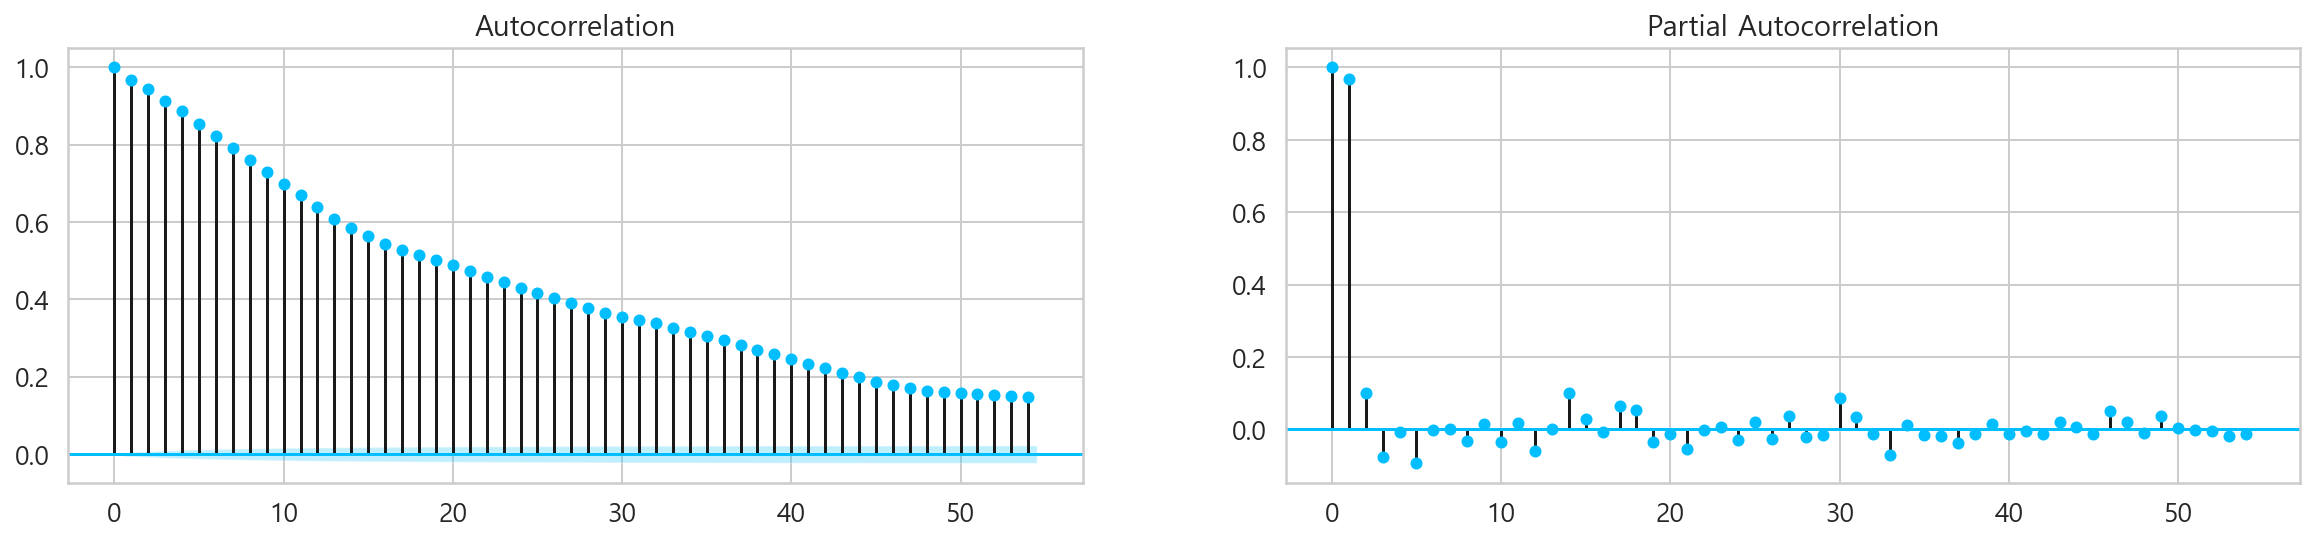

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,4))

plot_acf(df['AMT'], ax=ax[0])
plot_pacf(df['AMT'],ax=ax[1])
plt.show()

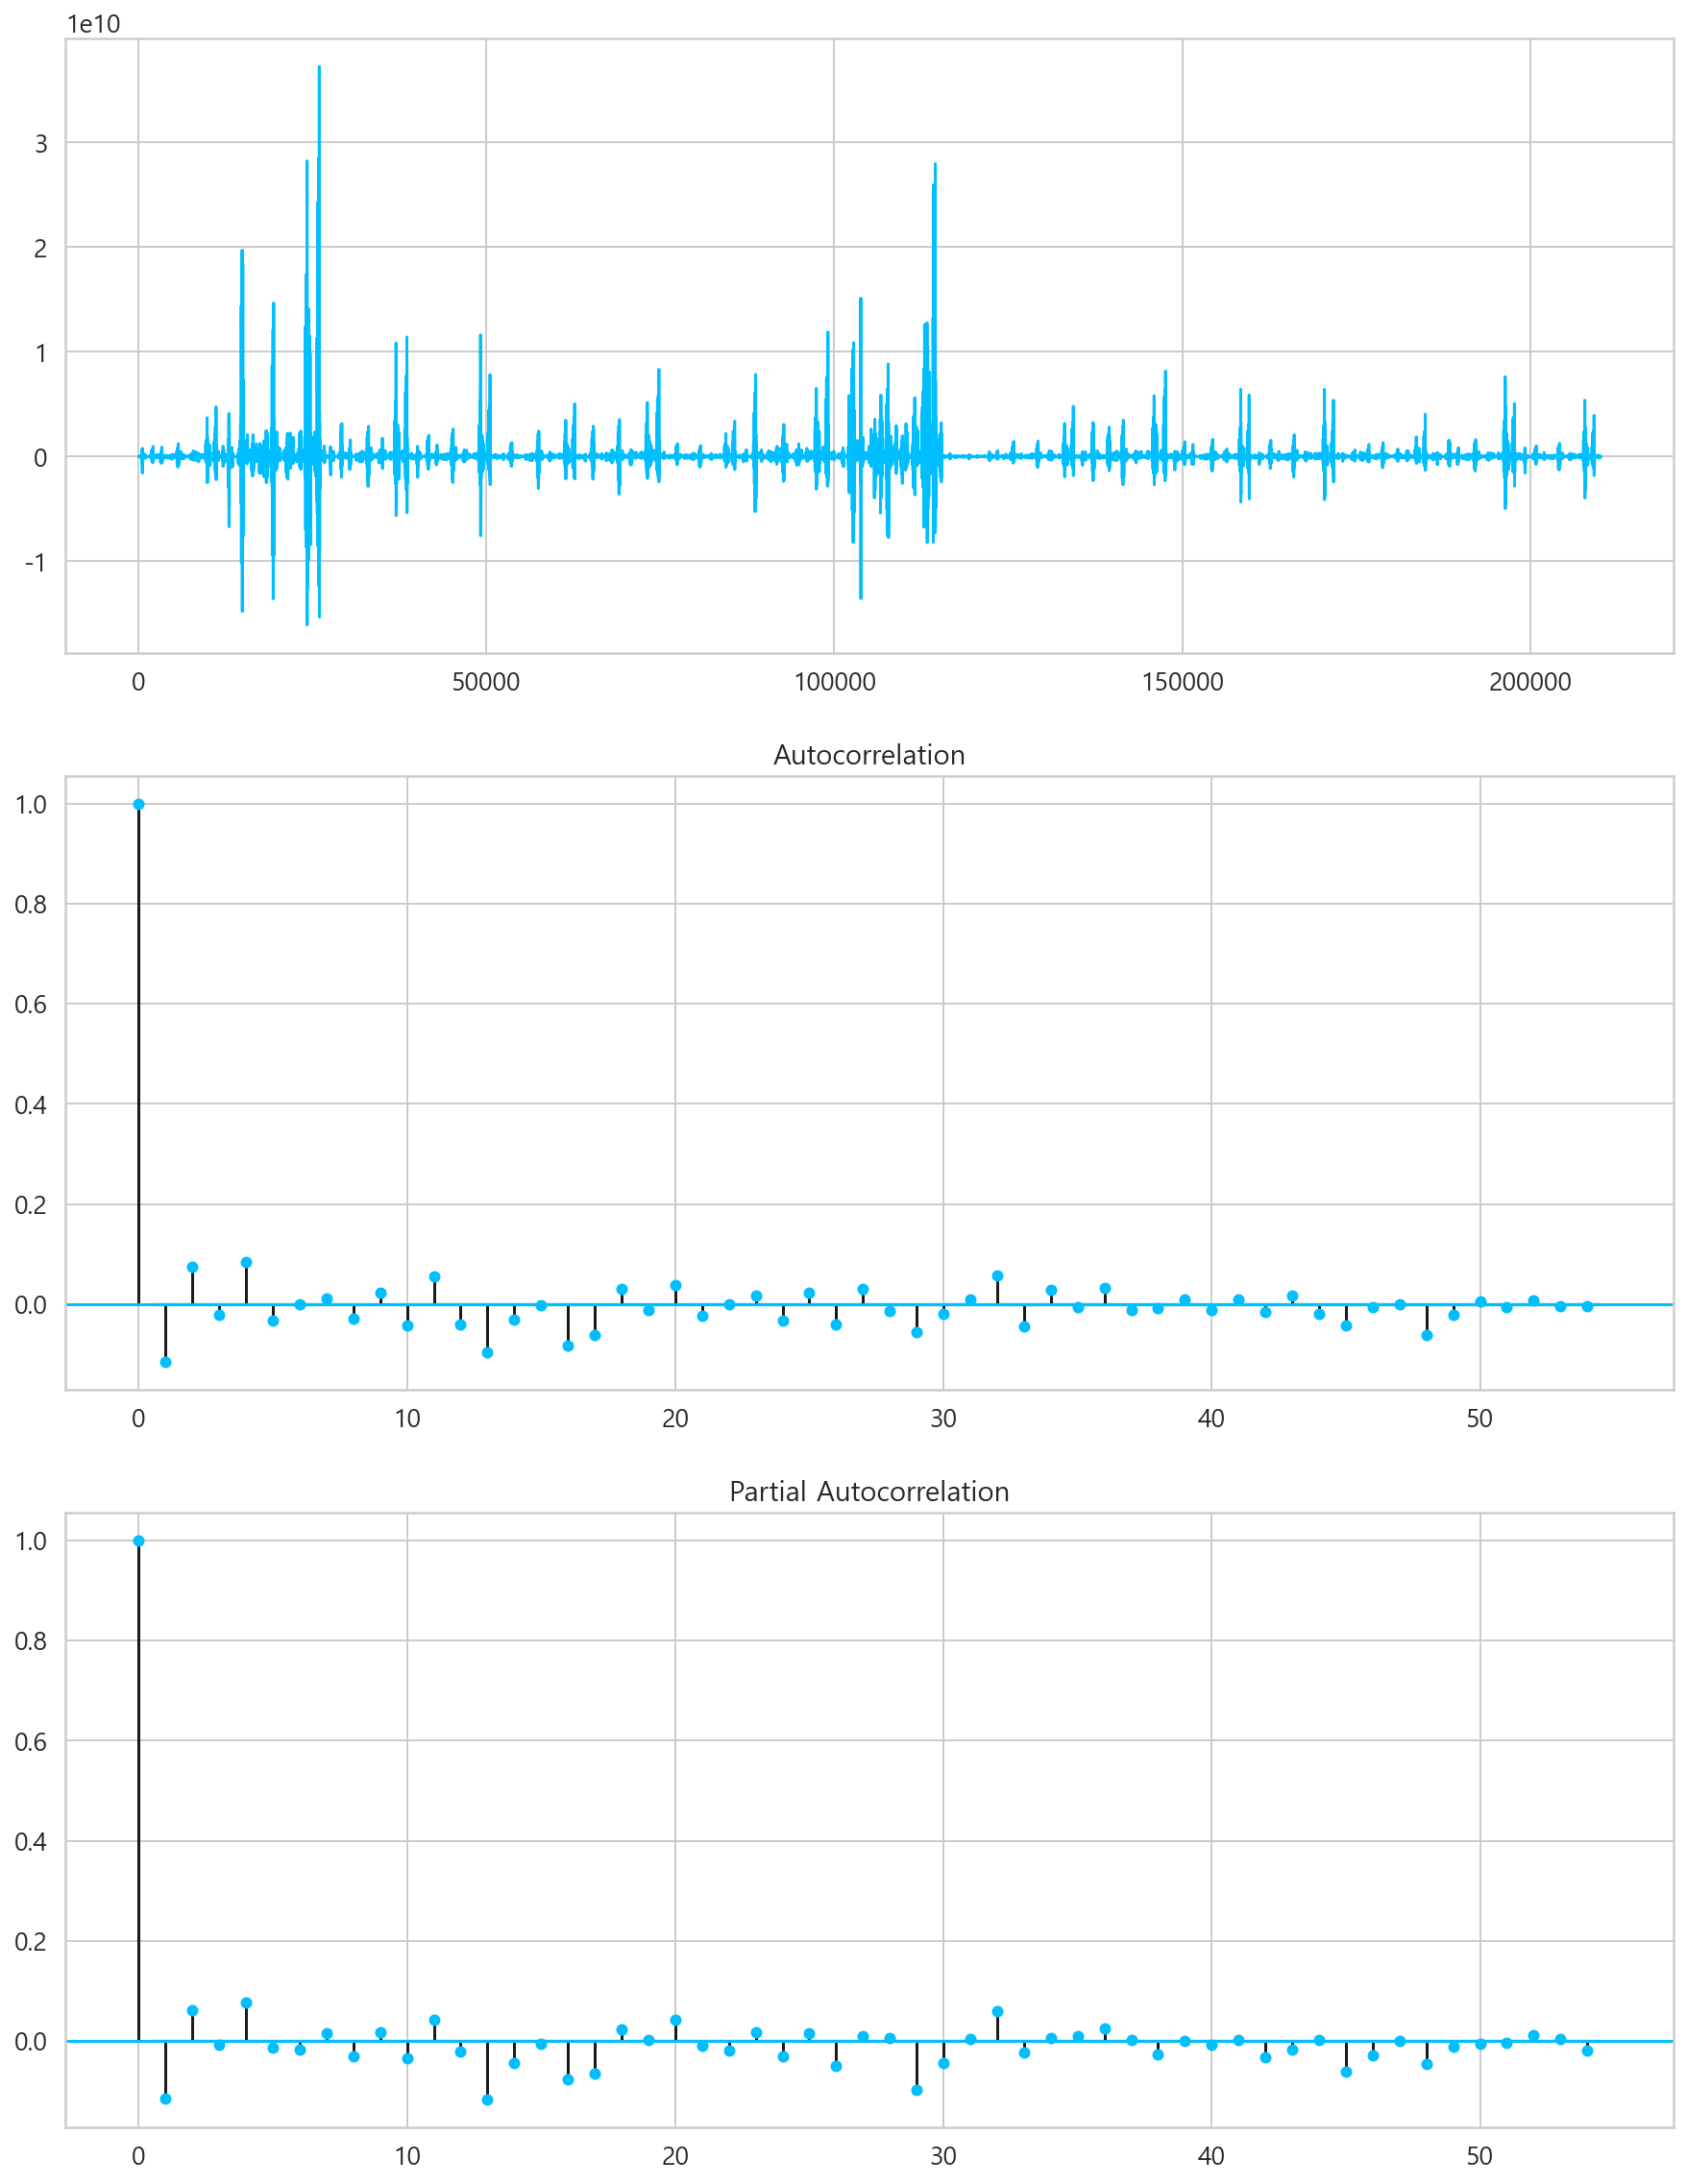

In [37]:
diff_1=df['AMT'].diff(periods=1).iloc[1:]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
diff_1.plot(ax=ax[0])
plot_acf(diff_1, ax=ax[1])
plot_pacf(diff_1, ax=ax[2])
plt.show()

## Create Model

In [153]:
y_s_train

100322    10.126671
100323     9.546884
100324    10.398214
100325     9.952325
100326    10.463132
            ...    
115428    20.516208
115429    20.397922
115430    20.356413
115431    20.273904
115432    20.187434
Name: AMT, Length: 14214, dtype: float64

In [160]:
np.asarray(x_s_train)

array([[8, 0, 0, ..., 1, 0, Timestamp('2019-05-01 00:00:00')],
       [8, 0, 0, ..., 0, 0, Timestamp('2019-09-01 00:00:00')],
       [8, 0, 0, ..., 0, 0, Timestamp('2019-10-01 00:00:00')],
       ...,
       [8, 39, 4, ..., 3, 1, Timestamp('2020-01-01 00:00:00')],
       [8, 39, 4, ..., 3, 2, Timestamp('2020-02-01 00:00:00')],
       [8, 39, 4, ..., 1, 3, Timestamp('2020-03-01 00:00:00')]],
      dtype=object)

In [163]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(endog=y_s_train, exog=np.asarray(x_s_train),order=(0,1,1), dates=df_num.DATE)
model_fit = model.fit(trend='nc',full_output=True, disp=1)
print(model_fit.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

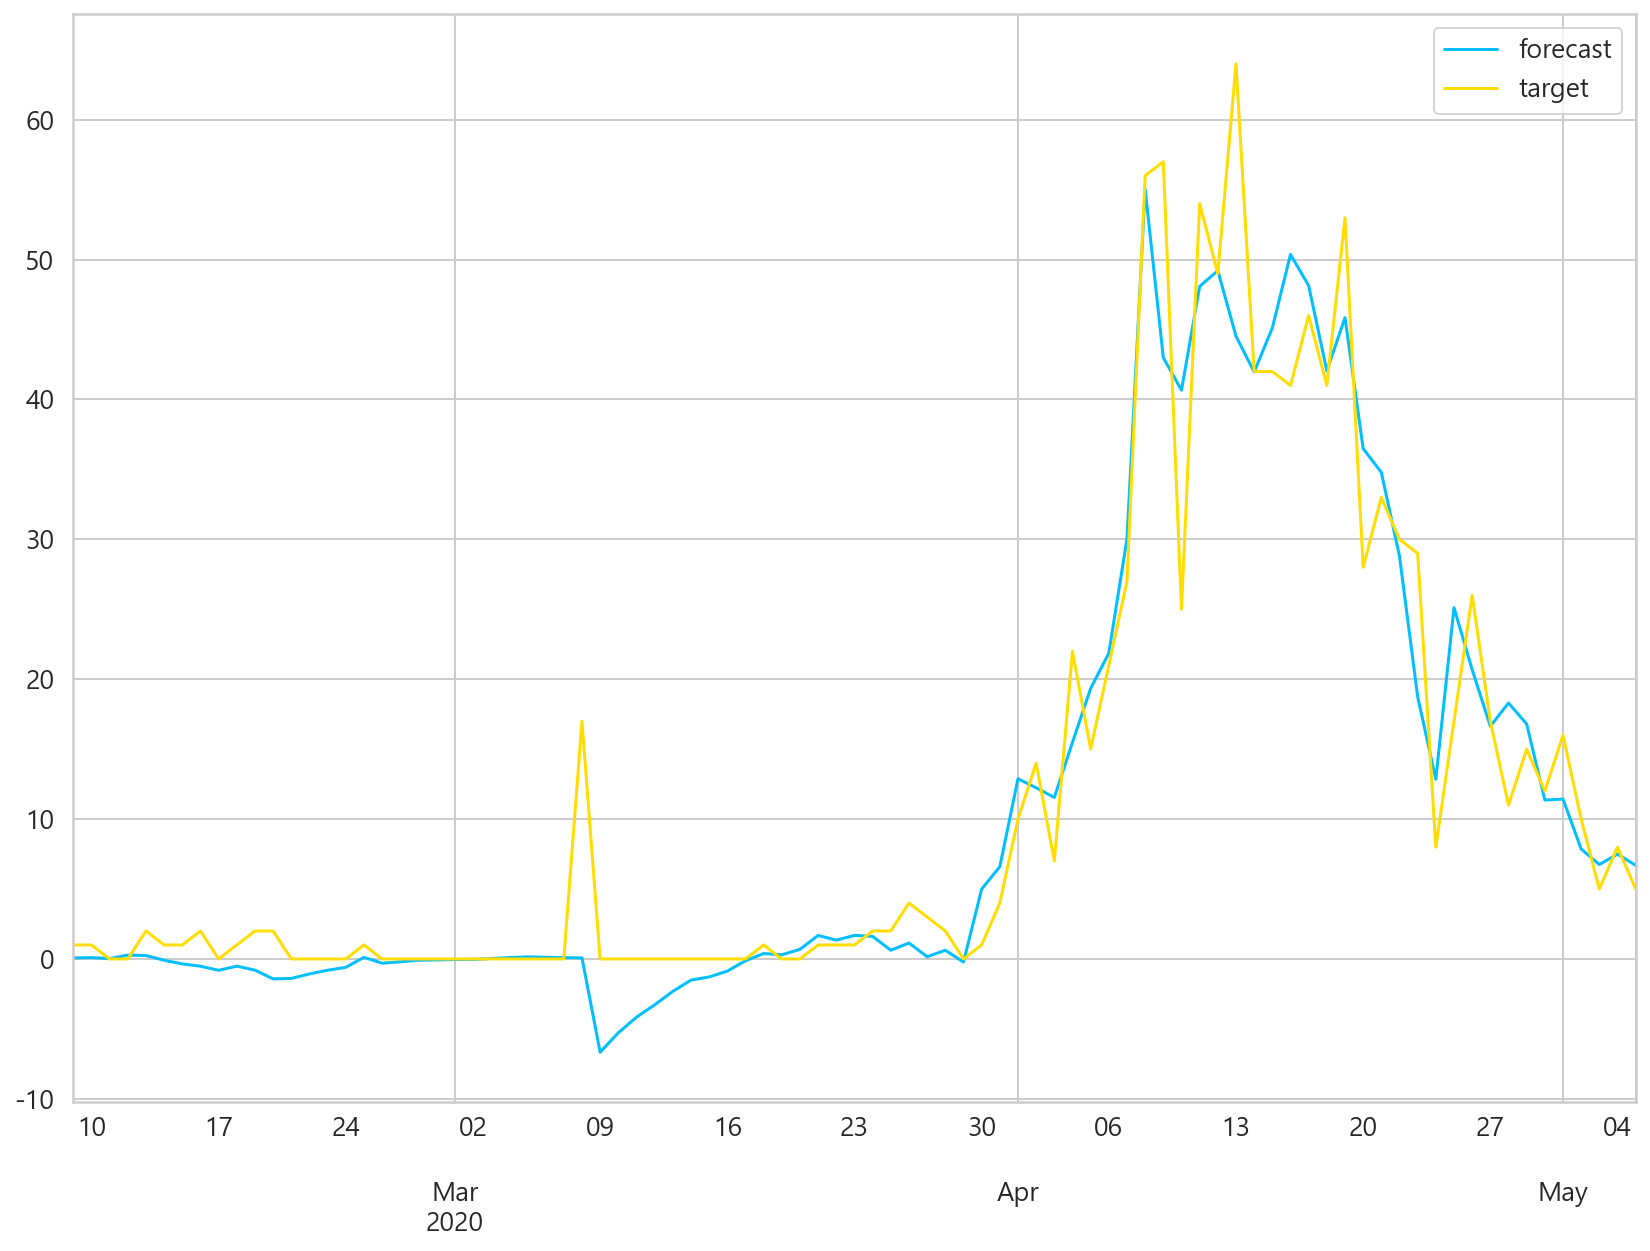

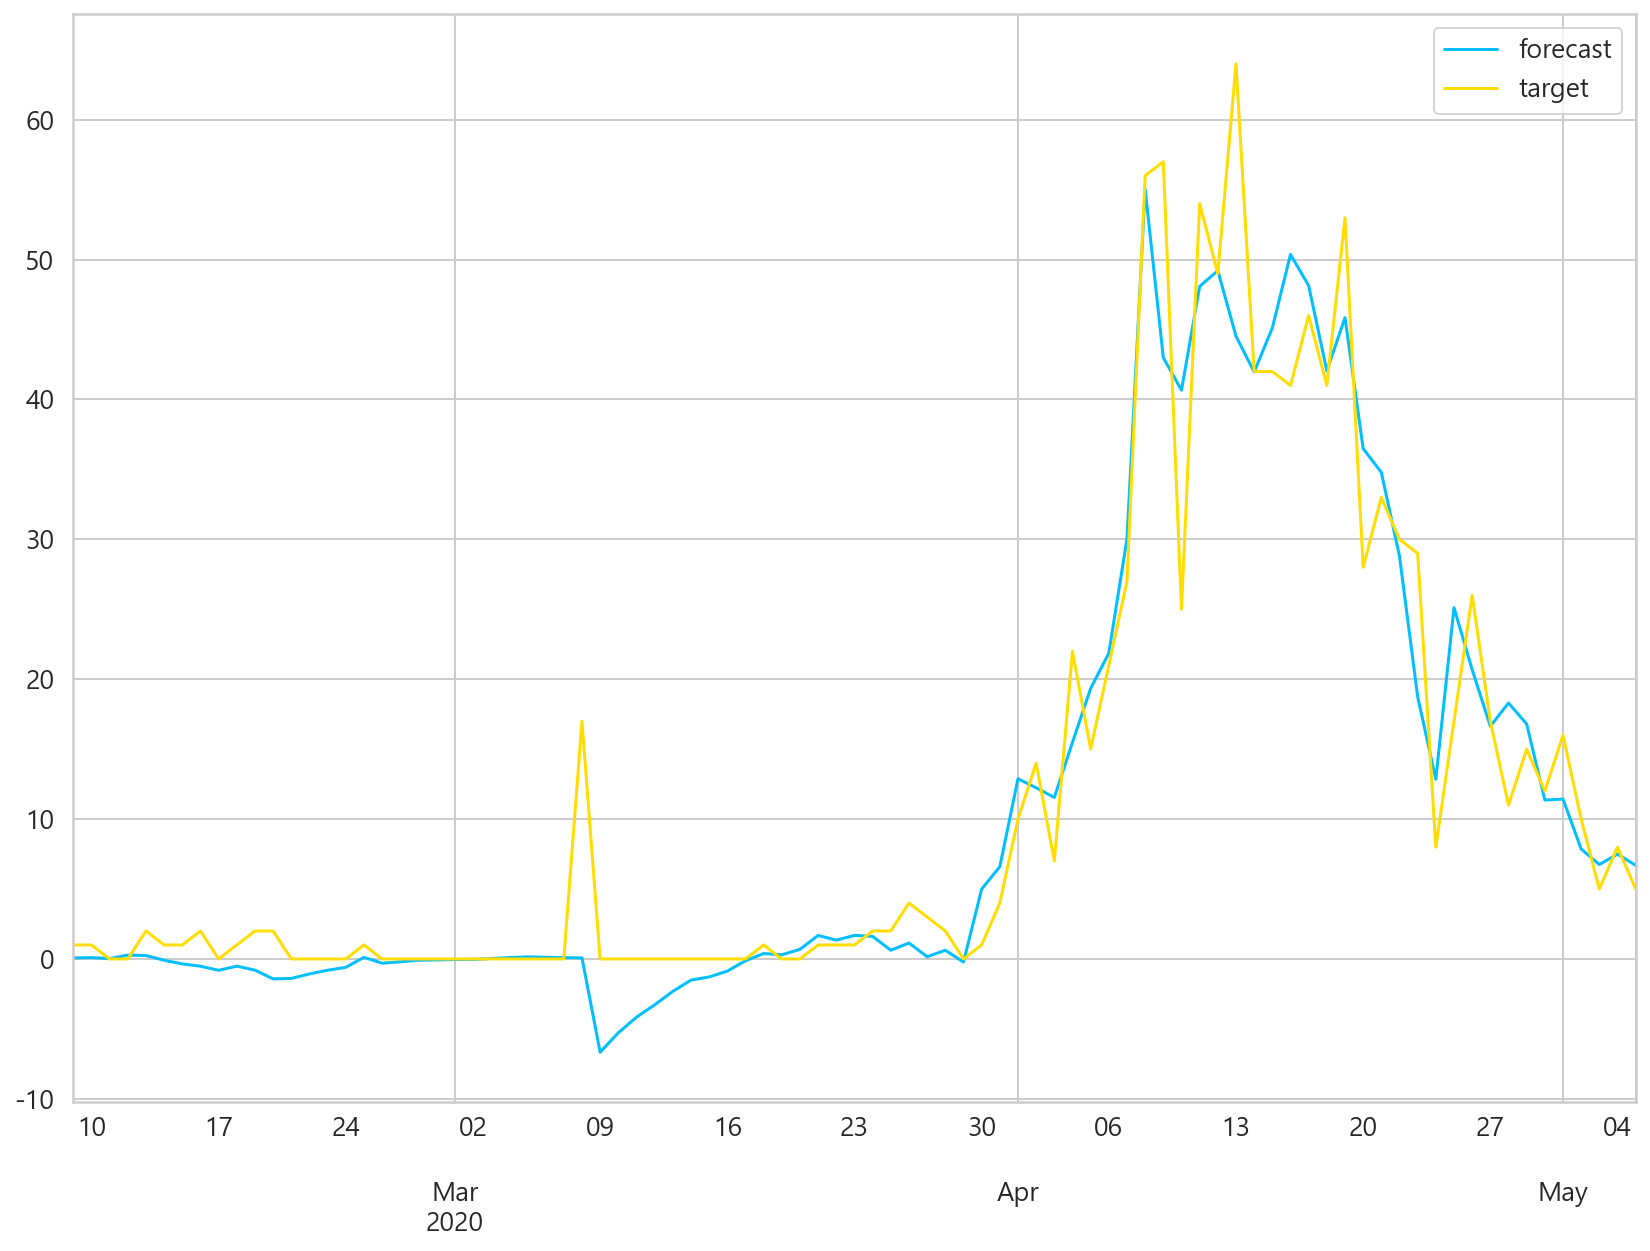

In [271]:
model_fit.plot_predict()

In [272]:
fore = model_fit.forecast(exog=X_test, steps=14)
print(fore[0])

[ 8.33471962  8.44087915  9.02233707 10.53813257 10.61748509 11.39205194
  9.02198706  3.9528612   1.54733571  1.50331211  0.03354425 -3.04163557
 -7.3480227  -9.70370893]


In [273]:
arima_fore = pd.DataFrame(index = y_test.index, data=fore[0], columns=['ARIMA'])

In [274]:
arima_fore

,ARIMA
Date,
2020-04-22,8.334720
2020-04-23,8.440879
2020-04-24,9.022337
2020-04-25,10.538133
2020-04-26,10.617485
2020-04-27,11.392052
2020-04-28,9.021987
2020-04-29,3.952861
2020-04-30,1.547336


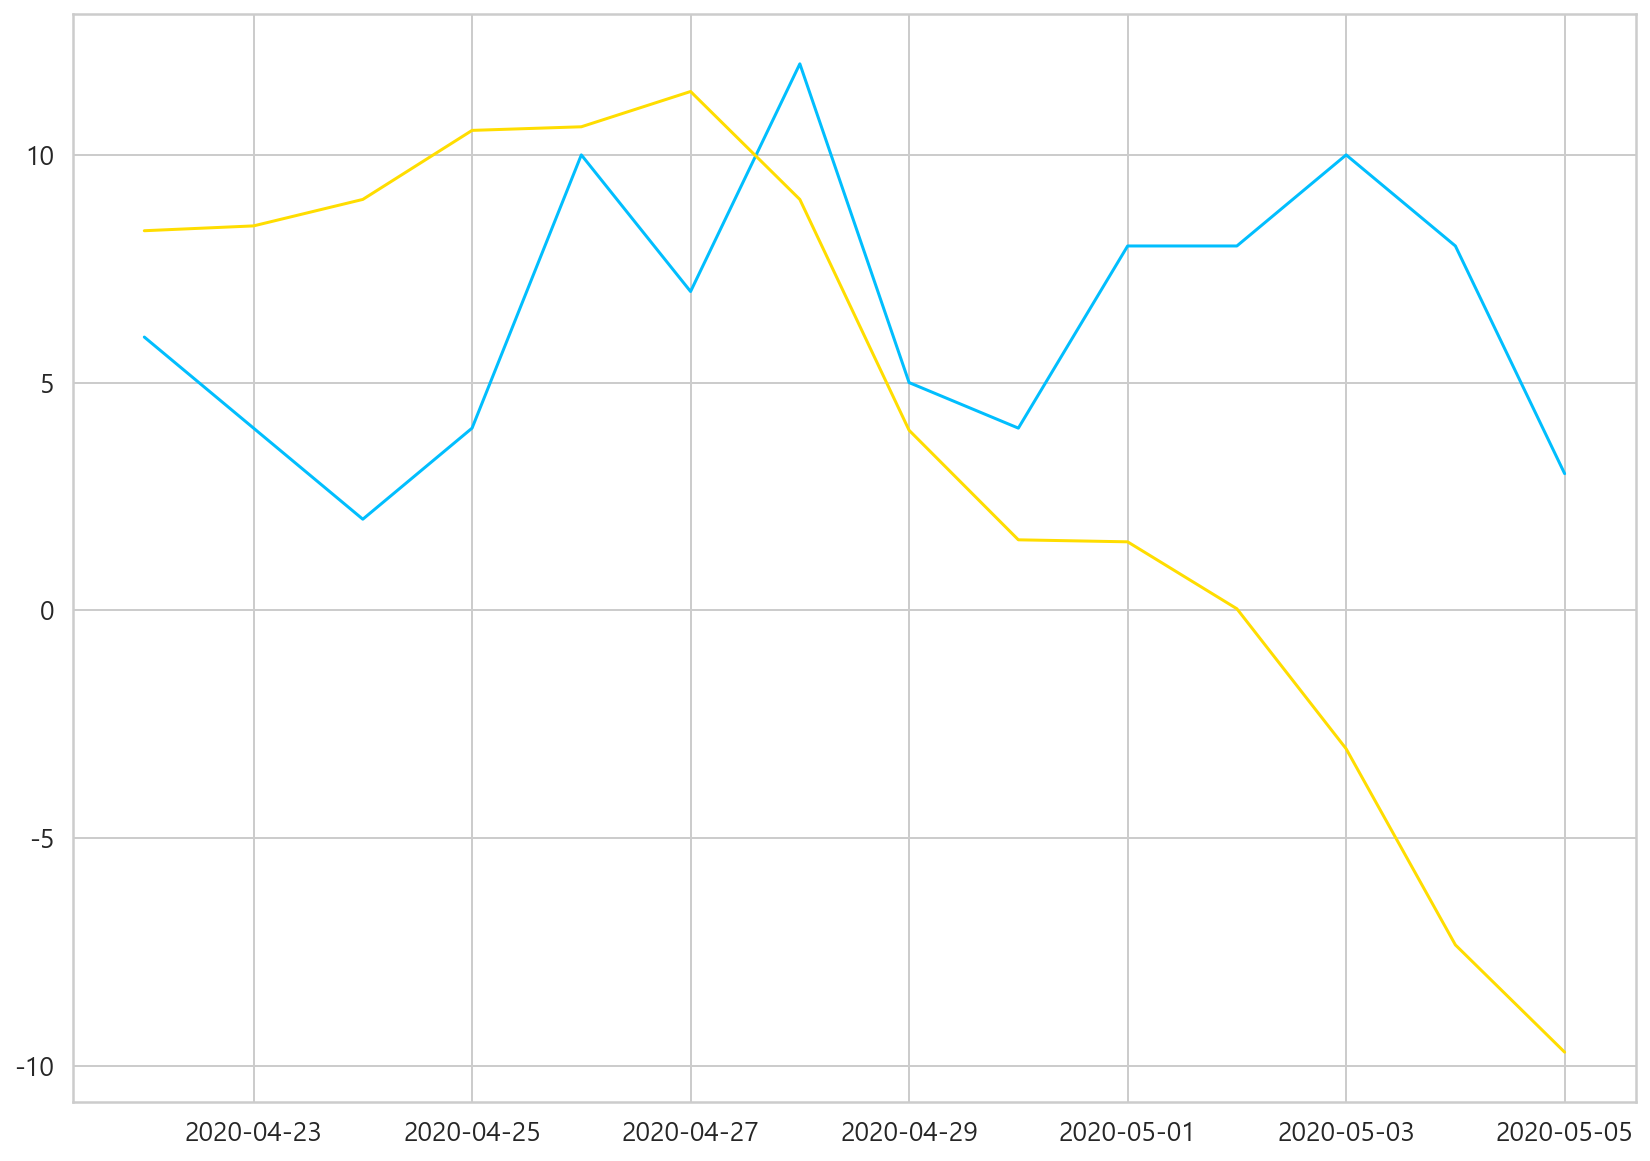

In [275]:
plt.plot(y_test, label='Real')
plt.plot(arima_fore, label='Pred')